In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import numpy as np

In [16]:
meta = pd.read_csv("geo_metadata.csv")

In [25]:
barcode_clones = pd.read_csv("barcode_clonotypes.csv")

In [28]:
# Merge the two dataframes on the GSM name and the ID in the expression matrix but dont modify column names
barcode_clones = barcode_clones.merge(meta, on=["gsm_name", "id_in_expmatrix"])

In [29]:
barcode_clones

,clone_id,barcode,gsm_name,id_in_expmatrix,patient_id,disease_state,time_point,time_point_type
0,12-0,CGTCACTCAGTCTTCC-12,GSM3583889,12,NHL-7,NHL,IP,IP
1,12-0,CTGATCCTCATGTCTT-12,GSM3583889,12,NHL-7,NHL,IP,IP
2,12-0,GTTTCTAAGACCACGA-12,GSM3583889,12,NHL-7,NHL,IP,IP
3,12-0,CCGTACTGTGCGATAG-12,GSM3583889,12,NHL-7,NHL,IP,IP
4,12-0,CGACTTCGTGGTTTCA-12,GSM3583889,12,NHL-7,NHL,IP,IP
...,...,...,...,...,...,...,...,...
49462,9-4500,CCATGTCTCTCCGGTT-9,GSM3583882,9,CLL-2,CLL,d12,Early
49463,9-4501,CAAGTTGCACAGCCCA-9,GSM3583882,9,CLL-2,CLL,d12,Early
49464,9-4502,AGCAGCCGTATGGTTC-9,GSM3583882,9,CLL-2,CLL,d12,Early
49465,9-4503,TCCACACTCCAATGGT-9,GSM3583882,9,CLL-2,CLL,d12,Early


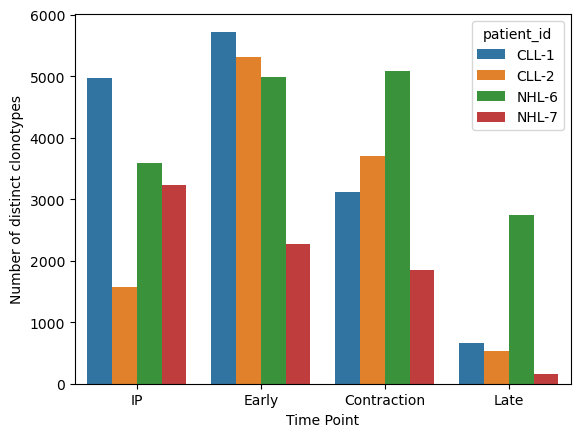

In [53]:
counts_per_timepoint = barcode_clones.groupby(["time_point_type", "patient_id"]).count().reset_index()[["time_point_type", "patient_id", "clone_id"]]
order_of_timepoints = {"IP": 0, "Early": 1, "Contraction": 2, "Late": 3}
counts_per_timepoint["time_point_idx"] = counts_per_timepoint["time_point_type"].map(order_of_timepoints)

sns.barplot(x="time_point_idx", y="clone_id", hue="patient_id", data=counts_per_timepoint)
plt.xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
plt.xlabel("Time Point")
plt.ylabel("Number of distinct clonotypes")
plt.show()

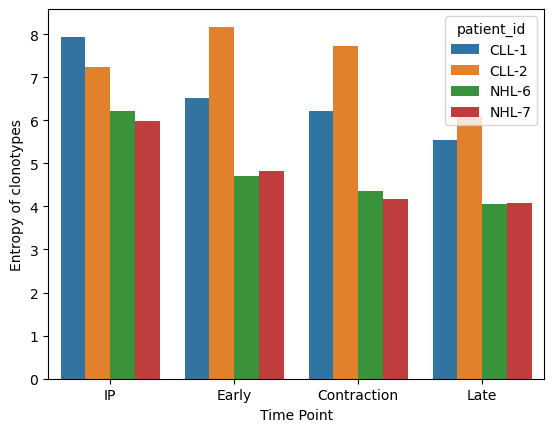

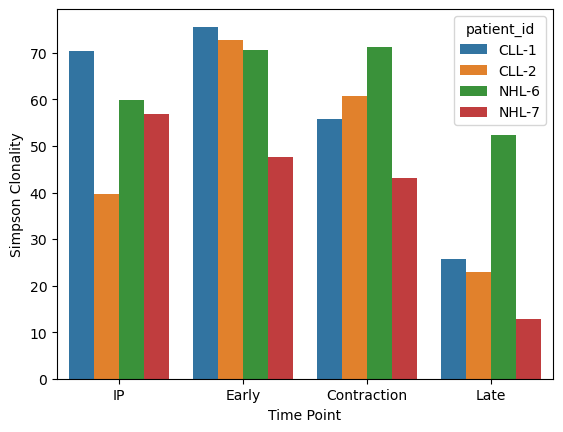

In [80]:
# Measure the entropy of the clonotypes per time point
def clonal_entropy(clone_labels):
    value,counts = np.unique(clone_labels, return_counts=True)
    return entropy(counts)

def simpson_clonality(clone_labels):
    value,counts = np.unique(clone_labels, return_counts=True)
    return np.sqrt(np.sum(np.square(counts)))

entropy_per_timepoint = barcode_clones.groupby(["time_point_type", "patient_id"]).agg({"clone_id": clonal_entropy, "barcode": simpson_clonality}).reset_index()
entropy_per_timepoint["time_point_idx"] = counts_per_timepoint["time_point_type"].map(order_of_timepoints)

sns.barplot(x="time_point_idx", y="clone_id", hue="patient_id", data=entropy_per_timepoint)
plt.xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
plt.xlabel("Time Point")
plt.ylabel("Entropy of clonotypes")
plt.show()

sns.barplot(x="time_point_idx", y="barcode", hue="patient_id", data=entropy_per_timepoint)
plt.xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
plt.xlabel("Time Point")
plt.ylabel("Simpson Clonality")
plt.show()


In [81]:
# look at most comomon in IP and follow them
barcode_clones.query("time_point_type == 'IP'")["clone_id"].value_counts()[:10]

12-0    150
1-0     141
16-0    105
1-1     101
12-1     95
16-1     91
16-2     69
16-3     68
12-2     65
12-3     50
Name: clone_id, dtype: int64